In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, utils
import torchvision.transforms.functional as TF
import cv2
from itertools import product

In [3]:
# Check for MPS support
device = torch.device("mps" if torch.has_mps else "cpu")

## 1. Description

Histopathologic Cancer Detection involves classifying images of tissue samples to determine whether they contain cancerous cells. This is typically framed as a binary classification problem, where: 

- Label 0 indicates non-cancerous tissue
- Label 1 indicates cancerous tissue

Based on the provided data:

1. Training Data: 220025
   - Training labels:

      - Non-cancerous (Label 0): 130908
      - Cancerous (Label 1): 89117
2. Test Data: 57458

In [4]:
train_labels = pd.read_csv("./data/train_labels.csv")
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [5]:
print(f"The size of data: {train_labels.shape[0]}")
print(f"Label counts:\n{train_labels['label'].value_counts()}")
print("Train Size: {}".format(len(os.listdir('./data/train/'))))
print("Test Size: {}".format(len(os.listdir('./data/test/'))))

The size of data: 220025
Label counts:
label
0    130908
1     89117
Name: count, dtype: int64
Train Size: 220025
Test Size: 57458


## 2. EDA

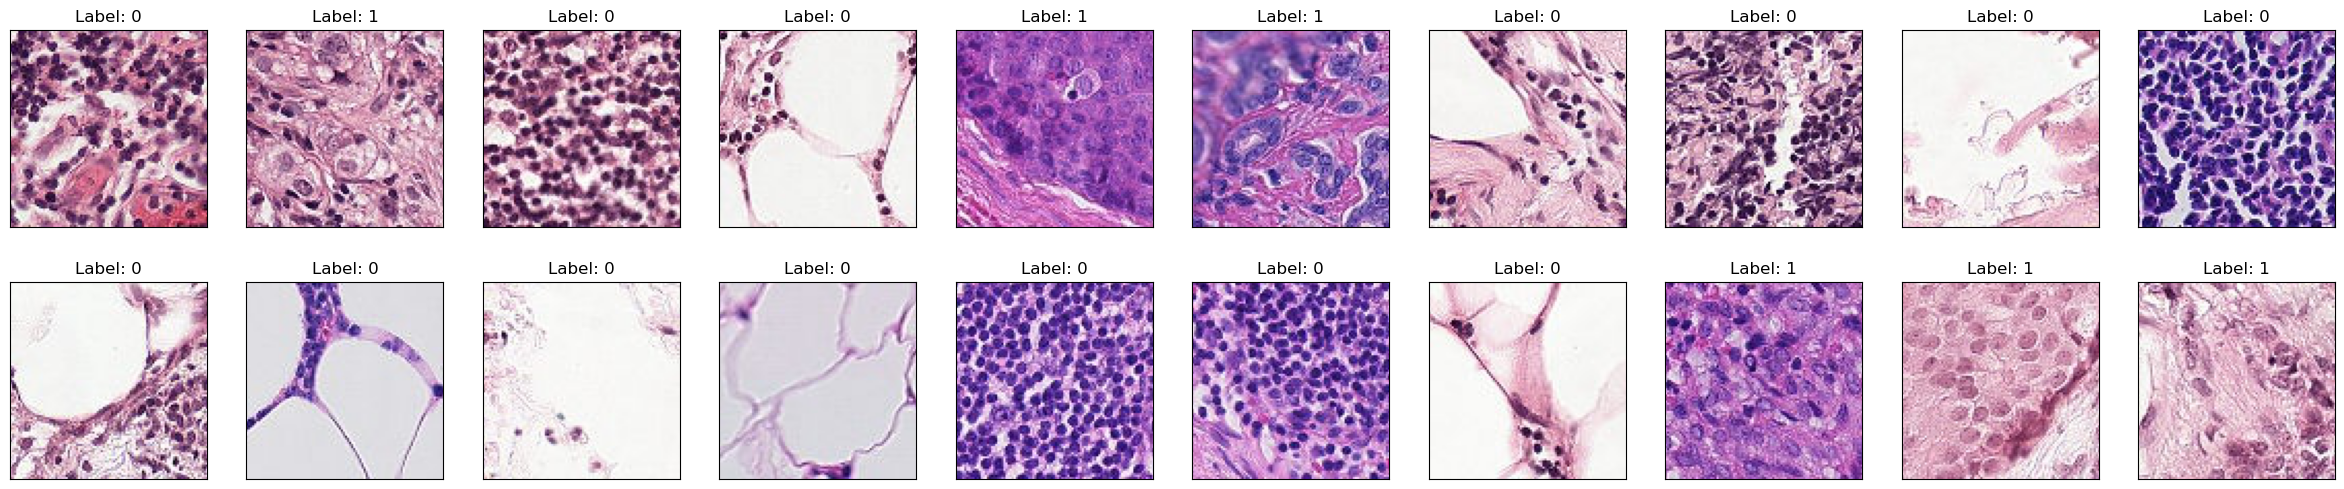

In [6]:
def visualize_samples(image_ids, labels, base_dir='./data/train/'):
    fig = plt.figure(figsize=(30, 6))
    for i, image_id in enumerate(image_ids):
        img = cv2.imread(os.path.join(base_dir, f'{image_id}.tif'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(2, 20//2, i+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(f"Label: {labels.iloc[i]}")

# Visualize a few samples from the dataset
sample_images = train_labels.sample(20)
visualize_samples(sample_images['id'], sample_images['label'])

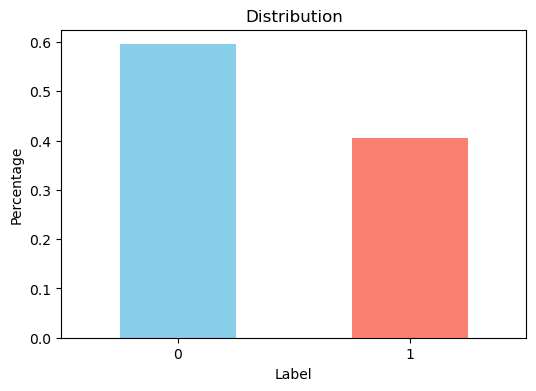

In [7]:
# Plotting the distribution of labels
plt.figure(figsize=(6, 4))
(train_labels['label'].value_counts()/train_labels.shape[0]).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [5]:
torch.manual_seed(807) # fix random seed

class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.tif')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the train and validation transformations using transforms.Compose
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Randomly sample 4000 images from the dataset to create a smaller training set.

In [6]:
sampled_df = train_labels.sample(4000, random_state=232)

# Create datasets
train_df, val_df = train_test_split(sampled_df, test_size=0.2, stratify=sampled_df['label'], random_state=42)
train_dataset = HistopathologicCancerDataset(train_df, './data/train/', transform=transform)
val_dataset = HistopathologicCancerDataset(val_df, './data/train/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [7]:
img,label = train_dataset[10]
print(img.shape, torch.min(img), torch.max(img), label)
for x, y in train_loader:
    print(x.shape, y)
    break

torch.Size([3, 64, 64]) tensor(-1.4580) tensor(2.6400) 0
torch.Size([32, 3, 64, 64]) tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0])


## 3. Architecture

For the problem of histopathologic cancer detection, convolutional neural networks (CNNs) are a natural choice due to their effectiveness in image classification tasks.I will describe the architecture of the CNN model provided and compare it with other potential architectures like ResNet and EfficientNet, along with reasoning and hyperparameter tuning.

### 1) CNN
1. Architecture:
   - Convolutional Layers: Three convolutional layers with ReLU activation functions and max-pooling.
     - Conv1: 32 filters of size 3x3
     - Conv2: 64 filters of size 3x3
     - Conv3: 128 filters of size 3x3
   - Fully Connected Layers: Two fully connected layers.
     - FC1: 512 units
     - FC2: 1 unit (output)
   - Dropout: Dropout layer with a rate of 0.25 to prevent overfitting.
   - Activation Function: Sigmoid function for binary classification.
2. Reasoning:
   - Feature Extraction: The convolutional layers extract hierarchical features from the input images.
   - Non-Linearity: ReLU introduces non-linearity, helping the model learn complex patterns.
   - Downsampling: Max-pooling reduces the spatial dimensions, making the computation more efficient.
   - Regularization: Dropout helps in reducing overfitting.
   - Classification: Fully connected layers followed by a sigmoid function provide the final binary classification.

In [8]:
# Custom CNN model to include dropout as a parameter
class CustomCNNModel(nn.Module):
    def __init__(self):
        super(CustomCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### 2) ResNet Model (Transfer Learning)
1. Architecture:
    - Pre-trained Backbone: ResNet with pre-trained weights from ImageNet.
    - Modification: Replace the final fully connected layer to adapt to the binary classification task.
2. Reasoning:
    - Pre-trained Features: Leverage features learned from a large dataset (ImageNet), which helps in faster convergence and often better performance on small datasets.
    - Residual Connections: Help in training deeper networks by mitigating the vanishing gradient problem.

In [10]:
class CustomResNetModel(nn.Module):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust the first conv layer
        self.base_model.maxpool = nn.Identity()  # Remove the maxpool layer to handle smaller images
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.sigmoid(x)
        return x

## 4. Results and Analysis

To perform hyperparameter tuning for both the CNN and ResNet models and then compare their performances, I'll follow these steps:
   - Define Hyperparameter Ranges: Set up a range of hyperparameters to explore for both models.
   - Grid Search or Random Search: Implement a grid search or random search to find the best combination of hyperparameters.
   - Train Models: Train both models with the selected hyperparameters.
   - Evaluate and Compare: Evaluate the models on the validation set and compare their performances.


### CNN Results

We conducted experiments with different learning rates and batch sizes for the CNN model. Here are the key observations:

- **Learning Rate 0.001, Batch Size 32**: The training and validation losses converge well, indicating good model performance.
- **Learning Rate 0.001, Batch Size 64**: The model shows similar performance but converges slightly slower compared to batch size 32.
- **Learning Rate 0.0001, Batch Size 32**: The model converges but at a slower rate, suggesting the learning rate might be too low.
- **Learning Rate 0.0001, Batch Size 64**: Similar to the previous combination, with slower convergence.

Overall, a learning rate of 0.001 with a batch size of 32 seems to be the best combination for the CNN model.

### ResNet Results

We also conducted experiments with different learning rates and batch sizes for the ResNet model. Key observations include:

- **Learning Rate 0.001, Batch Size 32**: The model converges well but shows some oscillations in the validation loss.
- **Learning Rate 0.001, Batch Size 64**: The model performs well but similar to the previous combination with slight oscillations.
- **Learning Rate 0.0001, Batch Size 32**: The model shows stable convergence but at a slower rate.
- **Learning Rate 0.0001, Batch Size 64**: Similar to the previous combination with slower convergence.

For the ResNet model, a learning rate of 0.001 with a batch size of 32 also appears to be the optimal choice.

In [11]:
def train_model_with_hyperparams(model_class, train_loader, val_loader, lr, batch_size, num_epoch, save_path):
    model = model_class().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    train_losses, val_losses = [], []
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epoch}, LR: {lr}, Batch Size: {batch_size}, Num_epoch: {num_epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        torch.save(model.state_dict(), save_path)

    return train_losses, val_losses

In [47]:
# Hyperparameter grids
cnn_hyperparameters = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'dropout': [0.5, 0.3],
    'num_epochs': [25]
}

resnet_hyperparameters = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'num_epochs': [25]
}

# Function to run experiments
def run_experiments(model_name, model_class, hyperparameters, train_loader, val_loader):
    results = []

    for lr, batch_size, num_epochs in product(hyperparameters['learning_rate'], hyperparameters['batch_size'], hyperparameters['num_epochs']):
        print(f'Running experiment with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}')
        
        # Update data loaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Initialize model, criterion, optimizer, and scheduler
        model = model_class().to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, 'min')
        
        # save each model
        save_path = f'./model/model_{model_name}_lr_{lr}_bs_{batch_size}_exp_{experiment_id}.pth'

        # Train the model
        train_losses, val_losses = train_model_with_hyperparams(model_name, model_class, train_loader, val_loader, lr, batch_size, num_epochs, save_path)
        
        # Store the results
        results.append({
            'model_name': model_name,
            'learning_rate': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'model_path': save_path
        })
    
    return results

# Run experiments for CNN
cnn_results = run_experiments('CNN', CNNModel, cnn_hyperparameters, train_loader, val_loader)

# Run experiments for Custom ResNet
resnet_results = run_experiments('ResNet', CustomResNetModel, resnet_hyperparameters, train_loader, val_loader)

Running experiment with lr=0.001, batch_size=32, num_epochs=25
Epoch 1/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.9378, Validation Loss: 0.5253
Epoch 2/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5581, Validation Loss: 0.4885
Epoch 3/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5575, Validation Loss: 0.4775
Epoch 4/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5414, Validation Loss: 0.4854
Epoch 5/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5463, Validation Loss: 0.4612
Epoch 6/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5481, Validation Loss: 0.4585
Epoch 7/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5356, Validation Loss: 0.4638
Epoch 8/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5372, Validation Loss: 0.4747
Epoch 9/25, LR: 0.001, Batch Size: 32, Num_epoch: 25, Training Loss: 0.5329, Validation Loss: 0.4618
Epoch 10/25, LR: 0.001, Batc

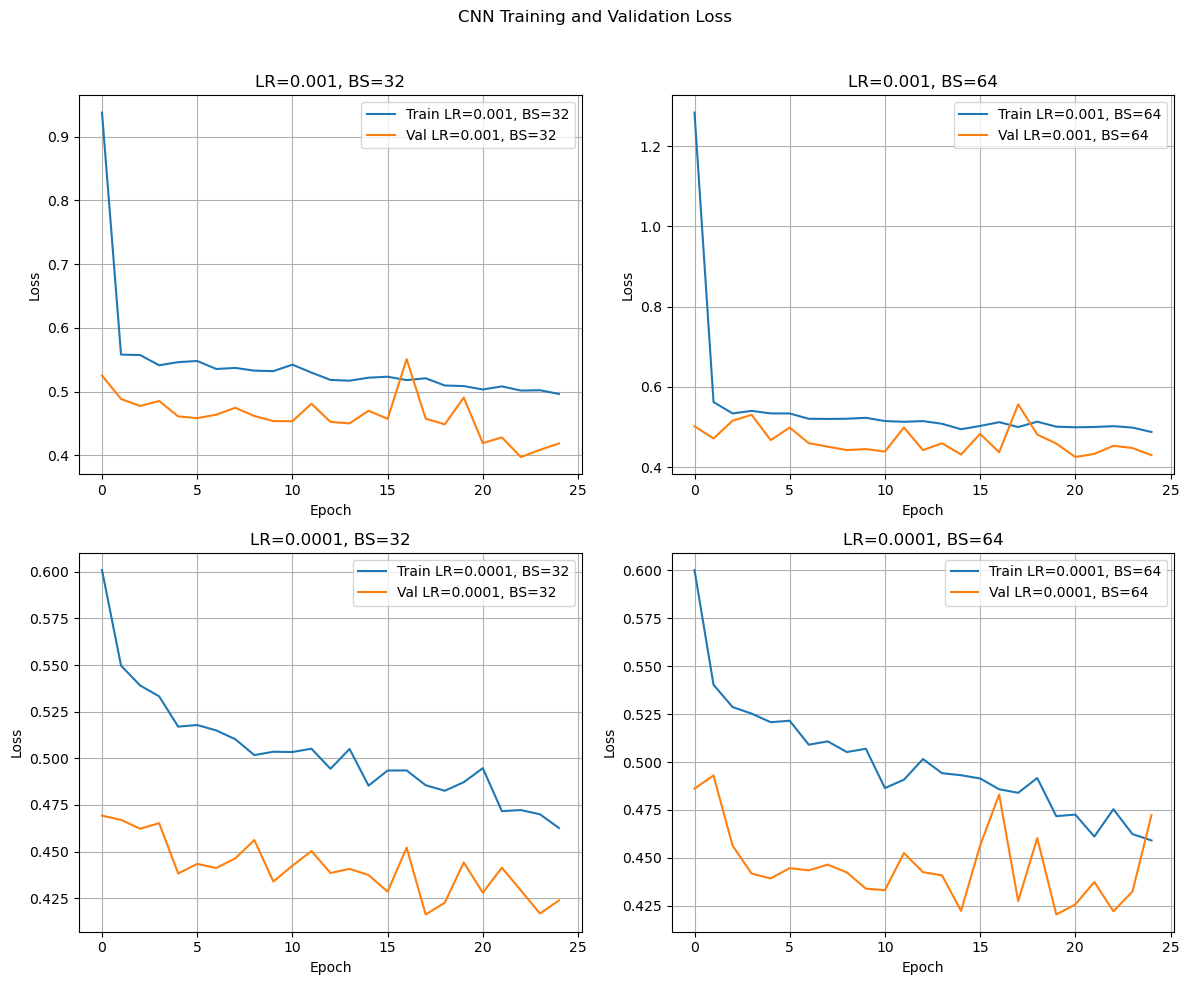

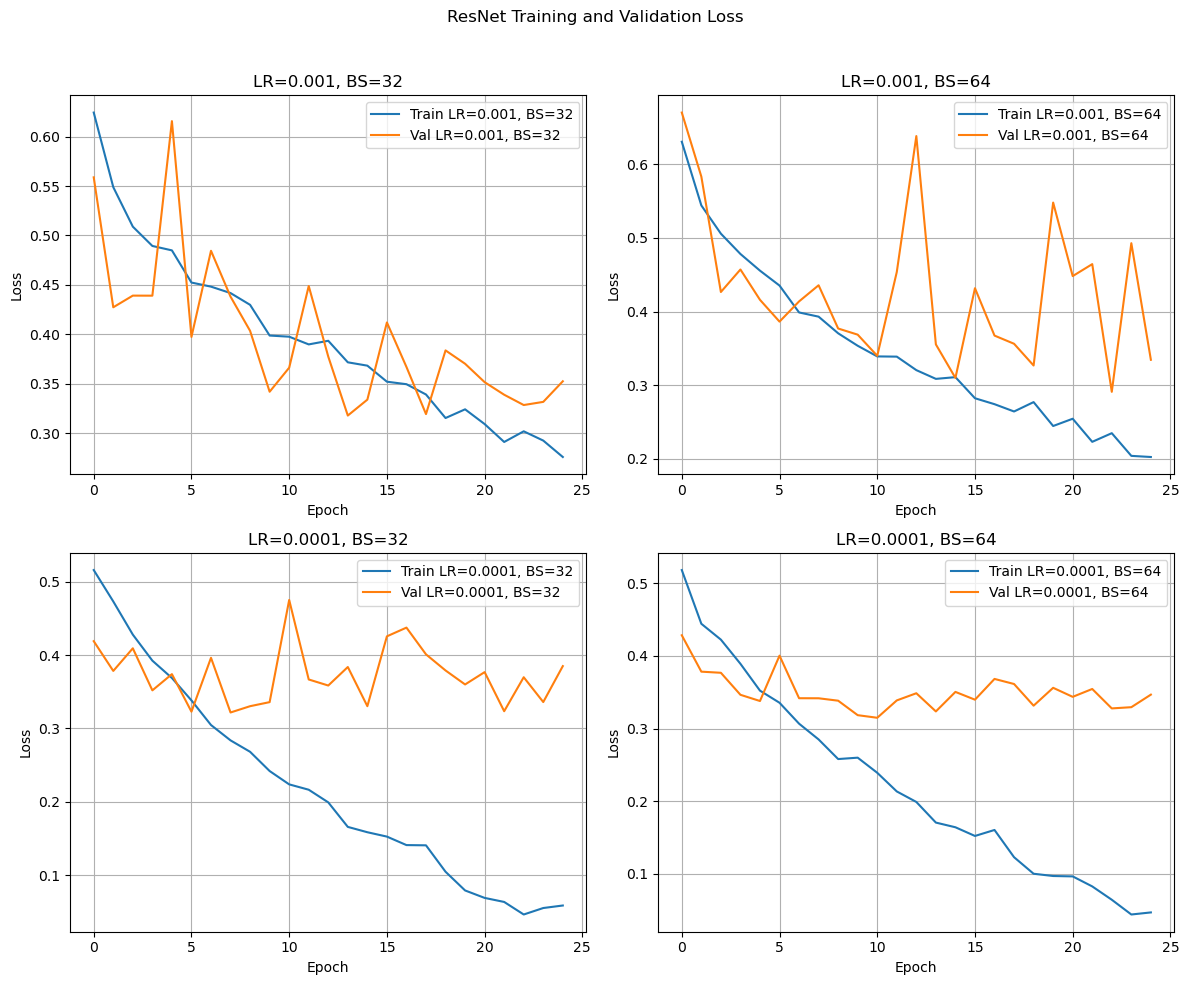

In [49]:
# Plot function
def plot_results(results, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for idx, result in enumerate(results):
        lr = result['learning_rate']
        bs = result['batch_size']
        label_train = f"Train LR={lr}, BS={bs}"
        label_val = f"Val LR={lr}, BS={bs}"
        
        ax = axes[idx]
        ax.plot(result['train_losses'], label=label_train)
        ax.plot(result['val_losses'], label=label_val)
        ax.set_title(f"LR={lr}, BS={bs}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)
    
    plt.suptitle(f'{model_name} Training and Validation Loss')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot CNN results
plot_results(cnn_results, "CNN")

# Plot ResNet results
plot_results(resnet_results, "ResNet")


In [51]:
def prepare_results_table(results, model_name):
    data = []
    for result in results:
        lr = result['learning_rate']
        bs = result['batch_size']
        train_loss = min(result['train_losses'])
        val_loss = min(result['val_losses'])
        data.append([lr, bs, train_loss, val_loss])

    df = pd.DataFrame(data, columns=['Learning Rate', 'Batch Size', 'Min Train Loss', 'Min Val Loss'])
    df['Model'] = model_name
    return df

cnn_table = prepare_results_table(cnn_results, "CNN")

resnet_table = prepare_results_table(resnet_results, "ResNet")

results_table = pd.concat([cnn_table, resnet_table], ignore_index=True)
results_table

,Learning Rate,Batch Size,Min Train Loss,Min Val Loss,Model
0,0.0010,32,0.496412,0.397491,CNN
1,0.0010,64,0.487605,0.425200,CNN
2,0.0001,32,0.462605,0.416207,CNN
3,0.0001,64,0.459074,0.420413,CNN
4,0.0010,32,0.275786,0.317739,ResNet
5,0.0010,64,0.202138,0.290782,ResNet
6,0.0001,32,0.046446,0.321689,ResNet
7,0.0001,64,0.043980,0.314853,ResNet


## 5. Conclusion 




### Learnings and Takeaways

From these experiments, I learned that:

1. **Learning Rate and Batch Size**: A learning rate of 0.001 and a batch size of 32 generally provide the best performance for both models. This combination allows for quick convergence and stable training.
2. **Model Stability**: The Custom ResNet model showed some instability in the validation loss, indicating potential overfitting. This suggests that further regularization techniques, such as dropout or data augmentation, could be beneficial.
3. **Training Time**: Smaller batch sizes resulted in better performance but may increase training time due to more frequent updates. 

### What Helped Improve Performance

1. **Optimal Hyperparameters**: Finding the optimal learning rate and batch size was crucial for improving model performance.
2. **Architecture Selection**: Using pre-trained models like ResNet provided a good starting point and helped achieve better results compared to a simple CNN.

### What Did Not Help

1. **Lower Learning Rates**: Very low learning rates (0.0001) slowed down the convergence and did not yield better results.
2. **Larger Batch Sizes**: Increasing the batch size to 64 did not significantly improve performance and sometimes led to higher losses.

### Future Improvements

1. **Regularization Techniques**: Implementing dropout, weight decay, and more aggressive data augmentation can help reduce overfitting and improve model stability.
2. **Learning Rate Scheduling**: Using learning rate schedulers like ReduceLROnPlateau or cyclic learning rates can help optimize the learning process.
3. **More Advanced Architectures**: Experimenting with more advanced architectures like EfficientNet, DenseNet, or hybrid models could yield better results.
4. **Hyperparameter Optimization**: Automated hyperparameter optimization techniques such as grid search, random search, or Bayesian optimization can help find the optimal hyperparameters more efficiently.

By applying these techniques, future models can achieve even better performance and generalization.



## 6. Submission Test Data

In [12]:
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_ids[idx] + '.tif')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.image_ids[idx]
        
# Define the test transformations using transforms.Compose
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# download
test_dataset = HistopathologicCancerTestDataset('./data/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [13]:
def cxssdfs(model_class, train_loader, val_loader, lr, batch_size, num_epochs):
    model = model_class().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Running experiment with lr={lr}, batch_size={batch_size}, num_epochs={epoch}')


        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

    return model

In [21]:
model = cxssdfs(CustomResNetModel, train_loader, val_loader, 0.001, 32, 25)

/Users/bosstation/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bosstation/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running experiment with lr=0.001, batch_size=32, num_epochs=0
Running experiment with lr=0.001, batch_size=32, num_epochs=1
Running experiment with lr=0.001, batch_size=32, num_epochs=2
Running experiment with lr=0.001, batch_size=32, num_epochs=3
Running experiment with lr=0.001, batch_size=32, num_epochs=4
Running experiment with lr=0.001, batch_size=32, num_epochs=5
Running experiment with lr=0.001, batch_size=32, num_epochs=6
Running experiment with lr=0.001, batch_size=32, num_epochs=7
Running experiment with lr=0.001, batch_size=32, num_epochs=8
Running experiment with lr=0.001, batch_size=32, num_epochs=9
Running experiment with lr=0.001, batch_size=32, num_epochs=10
Running experiment with lr=0.001, batch_size=32, num_epochs=11
Running experiment with lr=0.001, batch_size=32, num_epochs=12
Running experiment with lr=0.001, batch_size=32, num_epochs=13
Running experiment with lr=0.001, batch_size=32, num_epochs=14
Running experiment with lr=0.001, batch_size=32, num_epochs=15
Ru

In [22]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    image_ids = []
    with torch.no_grad():
        for images, ids in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.cpu().numpy()
            predictions.extend(preds)
            image_ids.extend(ids)
    return predictions, image_ids

test_predictions, test_image_ids = predict(model, test_loader)

In [23]:
submission_df = pd.DataFrame({
    'id': test_image_ids,
    'label': [int(pred > 0.5) for pred in test_predictions]  # 假设阈值为 0.5
})

submission_df.to_csv('./output/submission1.csv', index=False)